= 必备设置

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from abc import ABC , abstractmethod


def solve_helmholtz_fd(lam, mu, N=2001):
    """
    使用有限差分法求解Helmholtz方程: u'' + λ²u = sin(μx), u(-1)=u(1)=0
    参数:
        lam: λ参数（波数）
        mu: μ参数（源项频率）
        N: 网格点数（奇数，确保包含x=0）
    返回:
        x: 网格点坐标 [N, 1]
        u: 数值解 [N, 1]
    """
    # 创建网格
    x = np.linspace(-1, 1, N)
    dx = x[1] - x[0]
    
    # 构建系数矩阵 A (三对角矩阵)
    main_diag = (-2/dx**2) + lam**2  # 主对角线
    off_diag = 1/dx**2               # 次对角线
    
    diagonals = [
        np.full(N-1, off_diag),    # 下对角线
        np.full(N, main_diag),     # 主对角线
        np.full(N-1, off_diag)     # 上对角线
    ]
    
    A = diags(diagonals, offsets=[-1, 0, 1], format='csr')
    
    # 构建右端项 b = sin(μx)
    b = np.sin(mu * x)
    
    # 应用边界条件 u(-1)=u(1)=0
    A[0, :] = 0
    A[0, 0] = 1
    b[0] = 0
    
    A[-1, :] = 0
    A[-1, -1] = 1
    b[-1] = 0
    
    # 求解线性系统
    u = spsolve(A, b)
    
    return x[:, None], u[:, None]
class Solver(nn.Module,ABC):
    """
    神经网络求解器的抽象类
    """
    def __init__(self,physical_information=False):
        """
        初始化求解器
        
        参数:
            x_u: 训练输入坐标 [N, input_dim]
            u:   对应真值/边界条件 [N, output_dim]
            lb:  输入下界 (标量或向量)
            ub:  输入上界 (标量或向量)
        """
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.lam=205.0
        self.mu=3.0
        self.lb=-1.0
        self.ub=1.0
        self.N_fd=2001
        self.boundary_x=np.array([[-1.0],[1.0]])
        self.boundary_u=np.array([[0.0],[0.0]])
        num_internal_points=500
        self.x_fd, self.u_fd = solve_helmholtz_fd(self.lam, self.mu, N=self.N_fd)
        indices=np.linspace(0,len(self.x_fd)-1,num_internal_points,dtype=int)
        internal_x=self.x_fd[indices]
        internal_u=self.u_fd[indices]
        x_u=np.vstack([self.boundary_x,internal_x])
        u=np.vstack([self.boundary_u,internal_u])
        self.lb = torch.tensor(self.lb, dtype=torch.float32).to(self.device)
        self.ub = torch.tensor(self.ub, dtype=torch.float32).to(self.device)
        # 注册训练数据
        self.x_u = torch.tensor(x_u, dtype=torch.float32).to(self.device)
        self.u = torch.tensor(u, dtype=torch.float32).to(self.device) 
        self.physical_information=physical_information
        if physical_information:
            self.x_f=torch.linspace(self.lb,self.ub,1000).view(-1,1).to(self.device)
            self.x_f.requires_grad=True

    @abstractmethod
    def net_u(self, x):
        pass

    def net_f(self, x):
        """计算PDE残差"""
        u = self.net_u(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        f = u_xx + (self.lam**2) * u - torch.sin(self.mu * x)
        return f
    
    def loss(self):
        """计算数据损失"""
        if self.physical_information:
            f_pred = self.net_f(self.x_f)
            loss_f = torch.mean(f_pred**2)
            loss_u = torch.mean((self.u - self.net_u(self.x_u)) ** 2)*1e8
            loss = loss_u + loss_f
            return loss
        u_pred = self.net_u(self.x_u)
        loss = torch.mean((self.u - u_pred) ** 2) *1e8
        return loss
    
    def fit(self, nIter):
        """训练网络"""
        super().train()
        history = {'loss': []}
        for i in range(nIter):
            self.optimizer.zero_grad()
            # 计算损失
            loss = self.loss()
            # 反向传播
            loss.backward()
            self.optimizer.step()
            self.scheduler.step(loss)
            # 记录历史
            history['loss'].append(loss.item())
            # 打印训练过程
            if (i+1) % 500 == 0:
                lr = self.optimizer.param_groups[0]['lr']
                print(f'Iter {i+1}/{nIter}, Loss: {loss.item():.3e}, LR: {lr:.2e}') 
        self.plot(history)       
        return history
    
    def predict(self, x):
        """预测结果"""
        super().eval()
        x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            u = self.net_u(x_tensor)
        return u.cpu().numpy()
    def plot(self, history):
        u_pred=self.predict(self.x_fd)
        plt.figure(figsize=(12,10))
        plt.plot(self.x_fd,self.u_fd,'k-',label='Finite Difference Solution',linewidth=2)
        plt.plot(self.x_fd,u_pred,'b--',label='DNN Prediction',linewidth=2)
        plt.scatter(self.x_u.detach().numpy(),self.u.detach().numpy(),color='red',s=20,zorder=5,label='Training Points')
        plt.xlabel('x',fontsize=14)
        plt.ylabel('u(x)',fontsize=14)
        plt.title(f'Helmholtz Equation Solution: λ={self.lam}, μ={self.mu}', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()
        plt.figure(figsize=(10,6))
        plt.semilogy(history['loss'],'k-',label='Total Loss',linewidth=2)
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.title('Training Loss History', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()

= 简单DNN

Iter 500/20000, Loss: 4.232e+01, LR: 1.00e-03
Iter 1000/20000, Loss: 1.729e+01, LR: 1.00e-03
Iter 1500/20000, Loss: 7.129e+00, LR: 1.00e-03
Iter 2000/20000, Loss: 4.293e+00, LR: 1.00e-03
Iter 2500/20000, Loss: 3.546e+00, LR: 1.00e-03
Iter 3000/20000, Loss: 3.087e+00, LR: 1.00e-03
Iter 3500/20000, Loss: 2.617e+00, LR: 1.00e-03
Iter 4000/20000, Loss: 2.129e+00, LR: 1.00e-03
Iter 4500/20000, Loss: 1.645e+00, LR: 1.00e-03
Iter 5000/20000, Loss: 1.369e+00, LR: 1.00e-03
Iter 5500/20000, Loss: 1.060e+00, LR: 1.00e-03
Iter 6000/20000, Loss: 7.832e-01, LR: 1.00e-03
Iter 6500/20000, Loss: 6.709e-01, LR: 1.00e-03
Iter 7000/20000, Loss: 1.908e+01, LR: 1.00e-03
Iter 7500/20000, Loss: 2.532e-01, LR: 1.00e-03
Iter 8000/20000, Loss: 1.680e-01, LR: 1.00e-03
Iter 8500/20000, Loss: 1.347e-01, LR: 1.00e-03
Iter 9000/20000, Loss: 9.206e-02, LR: 1.00e-03
Iter 9500/20000, Loss: 5.001e-02, LR: 1.00e-03
Iter 10000/20000, Loss: 4.021e-02, LR: 1.00e-03
Iter 10500/20000, Loss: 2.594e-02, LR: 1.00e-03
Iter 11000/2

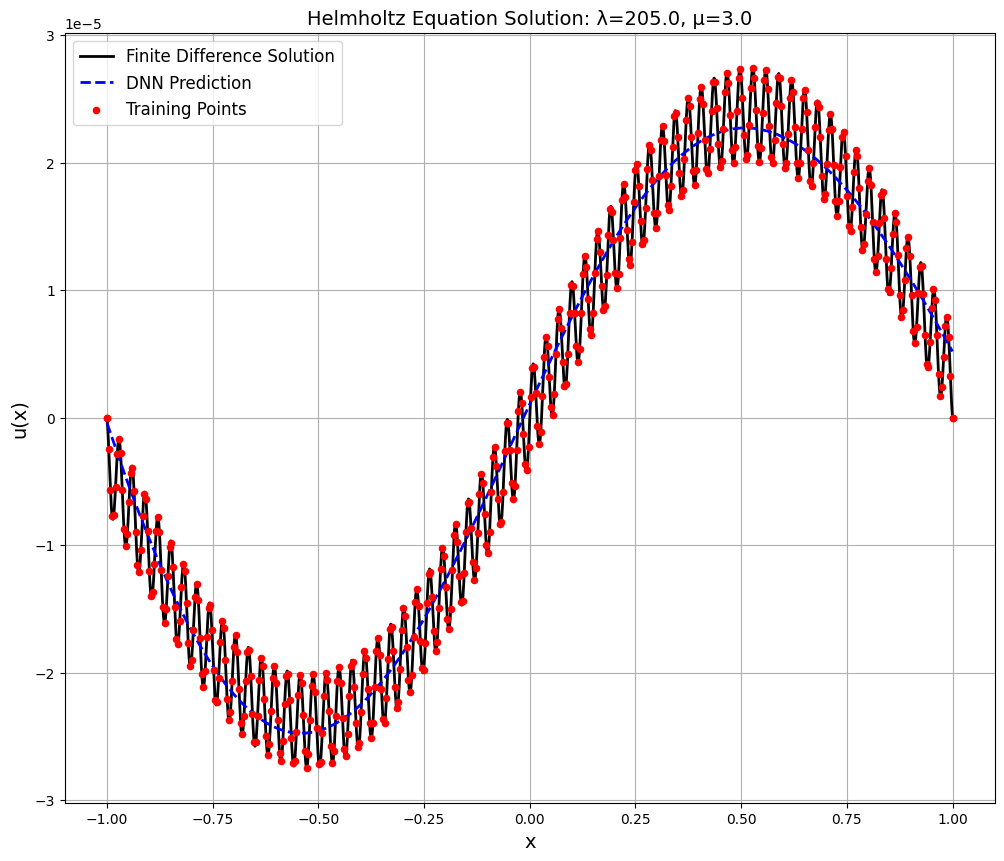

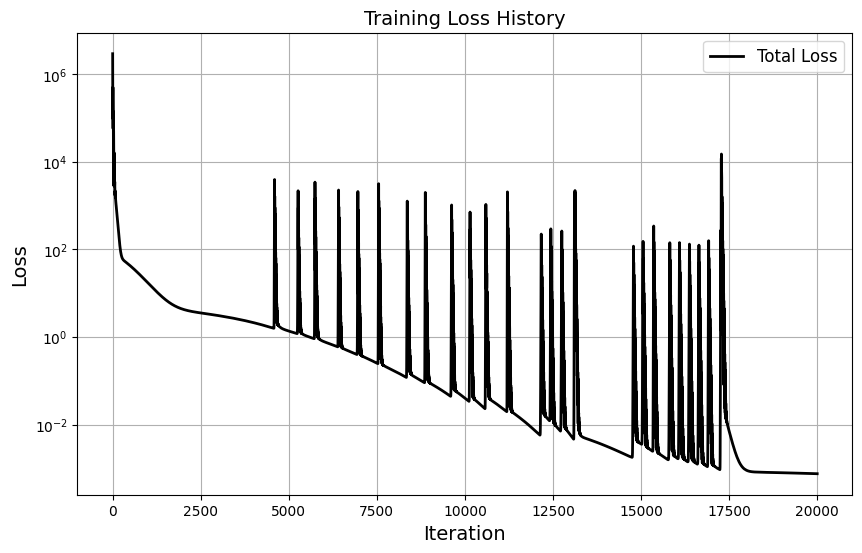

In [26]:
class DNNSolver(Solver):
    def __init__(self,layers):
        super().__init__()
        modules=[]
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i],layers[i+1]))
            if i<len(layers)-2:
                modules.append(nn.Tanh())
        self.net=nn.Sequential(*modules)
        self.to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.95, patience=1000)  
    def net_u(self,x):
        x_norm=2.0*(x-self.lb)/(self.ub-self.lb)-1.0
        u=self.net(x_norm)
        return u
if __name__=="__main__":
    layers=[1,40,40,40,40,1]
    dnn_solver=DNNSolver(layers)
    history=dnn_solver.fit(20000)

= 加入随机傅里叶特征

Total feature dim=256. All Fourier feature frequencies:
tensor([[-6.2626e+00],
        [-4.3578e+00],
        [-3.1255e+00],
        [-1.3084e-01],
        [ 5.2140e+00],
        [ 2.3898e+00],
        [-8.9521e-01],
        [ 3.2890e+00],
        [ 2.4805e+00],
        [ 1.7179e+00],
        [-3.2106e-01],
        [-5.3210e+00],
        [-2.3115e+00],
        [-8.8746e-01],
        [ 3.3094e+00],
        [ 3.9578e+00],
        [-5.1704e+00],
        [-3.5041e+00],
        [-2.5537e+00],
        [ 1.3310e+00],
        [-1.3433e+00],
        [-1.9932e+00],
        [ 5.5842e-01],
        [-9.0031e-04],
        [-4.7477e-01],
        [ 2.4522e+00],
        [ 4.7178e-02],
        [-3.6771e+00],
        [ 2.9849e+00],
        [ 5.6896e+00],
        [ 3.8787e+00],
        [ 3.8524e+00],
        [-1.2525e+01],
        [-8.7156e+00],
        [-6.2509e+00],
        [-2.6168e-01],
        [ 1.0428e+01],
        [ 4.7796e+00],
        [-1.7904e+00],
        [ 6.5779e+00],
        [ 4.9611e+00],
 

C:\Users\hp\AppData\Local\Temp\ipykernel_21912\132019304.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Iter 500/30000, Loss: 2.055e-01, LR: 1.00e-03
Iter 1000/30000, Loss: 3.775e-02, LR: 1.00e-03
Iter 1500/30000, Loss: 1.763e-02, LR: 1.00e-03
Iter 2000/30000, Loss: 9.792e-03, LR: 1.00e-03
Iter 2500/30000, Loss: 5.785e-03, LR: 1.00e-03
Iter 3000/30000, Loss: 4.096e-03, LR: 1.00e-03
Iter 3500/30000, Loss: 3.219e-03, LR: 1.00e-03
Iter 4000/30000, Loss: 2.637e-03, LR: 1.00e-03
Iter 4500/30000, Loss: 2.198e-03, LR: 1.00e-03
Iter 5000/30000, Loss: 1.715e-03, LR: 1.00e-03
Iter 5500/30000, Loss: 2.661e-01, LR: 1.00e-03
Iter 6000/30000, Loss: 2.970e-03, LR: 1.00e-03
Iter 6500/30000, Loss: 2.082e-03, LR: 9.50e-04
Iter 7000/30000, Loss: 1.741e-03, LR: 9.50e-04
Iter 7500/30000, Loss: 1.614e-03, LR: 9.02e-04
Iter 8000/30000, Loss: 1.523e-03, LR: 9.02e-04
Iter 8500/30000, Loss: 8.755e-02, LR: 8.57e-04
Iter 9000/30000, Loss: 1.321e-03, LR: 8.57e-04
Iter 9500/30000, Loss: 1.851e-03, LR: 8.57e-04
Iter 10000/30000, Loss: 1.223e-03, LR: 8.57e-04
Iter 10500/30000, Loss: 1.112e-03, LR: 8.57e-04
Iter 11000/3

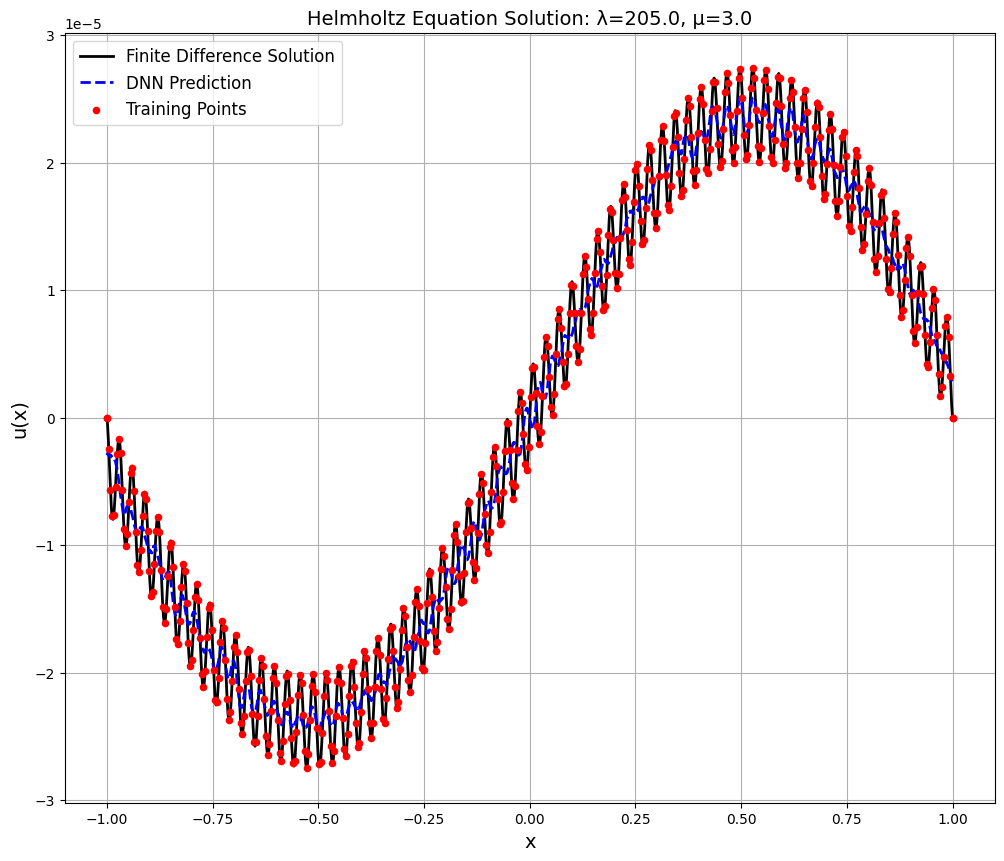

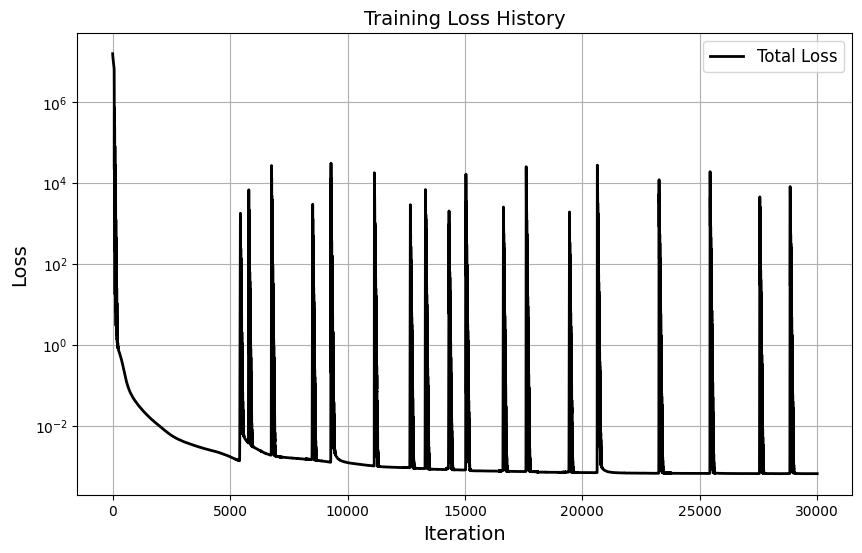

In [ ]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales):
        super().__init__()
        self.input_dim=input_dim
        self.base_feature_dim=base_feature_dim
        self.num_scales=num_scales
        base_freqs=(torch.rand(self.base_feature_dim,input_dim)-0.5)*2.0*np.pi
        all_freqs=[]
        for k in range(1,num_scales+1):
            scale=2.0**k
            all_freqs.append(scale*base_freqs)
        self.register_buffer('omega',torch.cat(all_freqs,dim=0))
        self.total_feature_dim=self.omega.shape[0]
        print(f"Total feature dim={self.total_feature_dim}. All Fourier feature frequencies:\n{self.omega}")
        phases=torch.rand(self.total_feature_dim)*2.0*np.pi
        self.register_buffer('phases',phases)
        with torch.no_grad():
            beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)
        self.beta=nn.Parameter(beta)
        self.scale=torch.sqrt(torch.tensor(2.0/self.total_feature_dim,dtype=torch.float32))
    def forward(self, x):
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features * self.scale * self.beta
        return features
class FourierFeatureSolver(Solver):
    def __init__(self,layers,base_feature_dim,num_scales):
        super().__init__()
        self.multi_scale_fourier_layer=MultiScaleFourierLayer(input_dim=1,base_feature_dim=base_feature_dim,num_scales=num_scales)
        input_dim=self.multi_scale_fourier_layer.total_feature_dim
        modules=[]
        modules.append(nn.Linear(input_dim,layers[0]))
        for i in range(0,len(layers)-1):
            modules.append(nn.ReLU())
            modules.append(nn.Linear(layers[i],layers[i+1]))
        self.net=nn.Sequential(*modules)
        self.to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.95, patience=1000)  
    def net_u(self,x):
        x_norm=2.0*(x-self.lb)/(self.ub-self.lb)-1.0
        x_features=self.multi_scale_fourier_layer(x_norm)
        u=self.net(x_features)
        return u

if __name__=="__main__":
    layers=[16,8,8,8,1]
    base_feature_dim=32
    num_scales=8
    fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
    history=fourier_solver.fit(30000)

= 加入物理信息

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\hp\AppData\Local\Temp\ipykernel_21912\132019304.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta=torch.tensor(1/torch.norm(self.omega,dim=1),dtype=torch.float32)


Total feature dim=256. All Fourier feature frequencies:
tensor([[-2.0196e-01],
        [ 3.2514e+00],
        [ 3.1290e+00],
        [-1.1153e-01],
        [ 3.2076e+00],
        [-1.2516e+00],
        [-6.7867e-01],
        [-5.4380e+00],
        [-1.2718e+00],
        [-6.7962e-01],
        [-1.3741e+00],
        [-4.7786e+00],
        [-5.9127e+00],
        [-7.6601e-01],
        [ 4.2738e+00],
        [ 5.6007e+00],
        [-4.9146e+00],
        [ 2.7735e+00],
        [-1.5041e+00],
        [ 5.4923e+00],
        [-3.8073e+00],
        [-4.2055e+00],
        [-3.0205e+00],
        [ 2.5473e+00],
        [-3.7210e+00],
        [-1.1496e+00],
        [ 2.8752e-01],
        [-4.5614e+00],
        [-5.0477e+00],
        [ 2.5765e-01],
        [ 5.8557e+00],
        [ 4.7773e+00],
        [-4.0392e-01],
        [ 6.5028e+00],
        [ 6.2579e+00],
        [-2.2306e-01],
        [ 6.4152e+00],
        [-2.5031e+00],
        [-1.3573e+00],
        [-1.0876e+01],
        [-2.5437e+00],
 

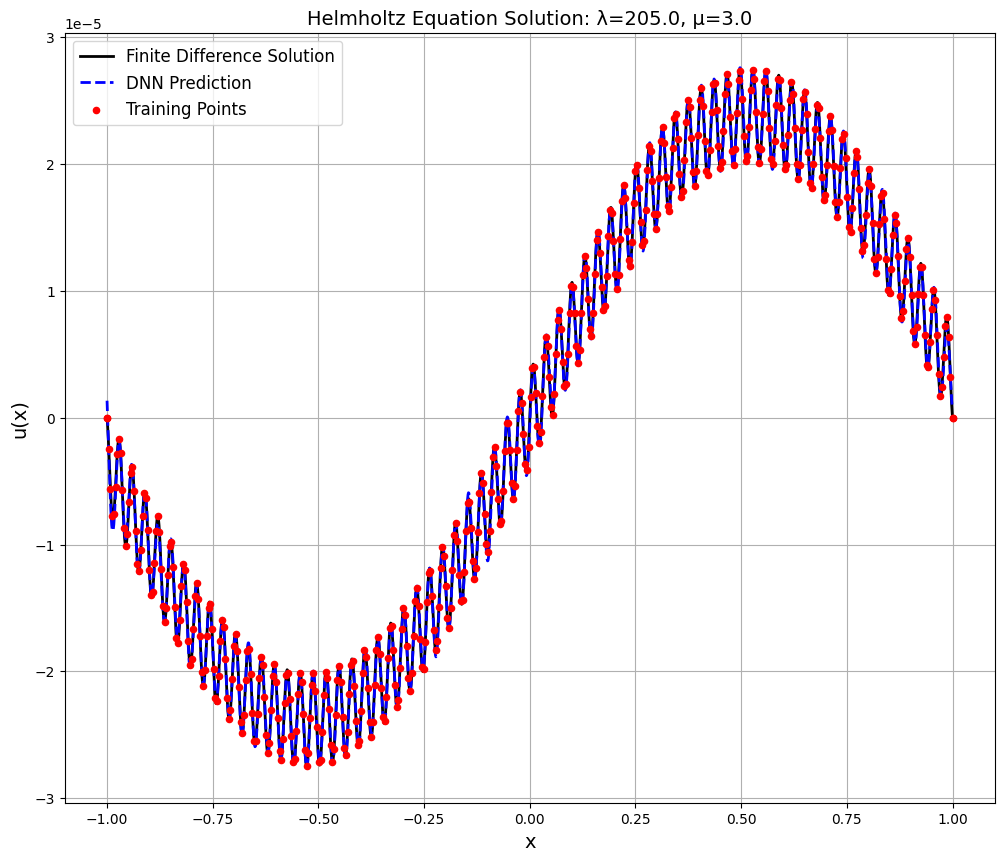

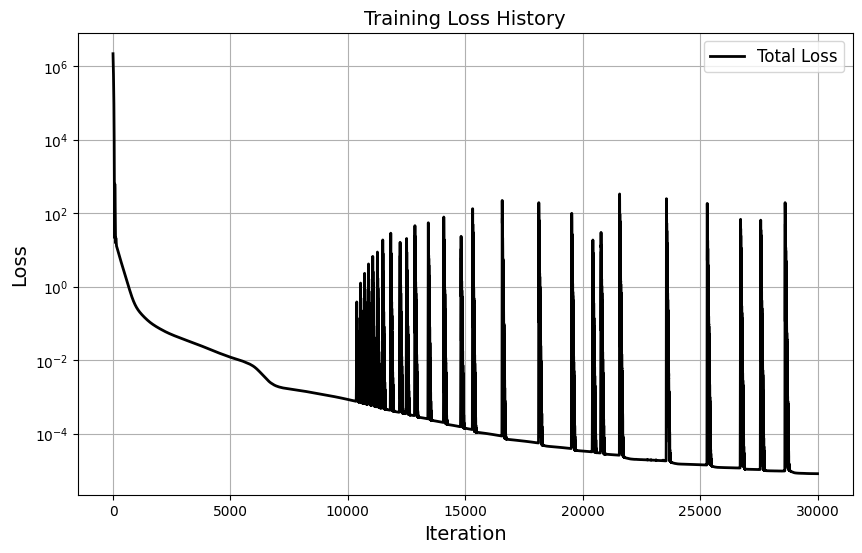

In [33]:
layers=[16,8,8,8,1]
base_feature_dim=32
num_scales=8
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales)
fourier_solver.physical_information=True
history=fourier_solver.fit(30000)